# **Treinando aprendizado - BootCamp módulo 1**
 
**Desafio**: Analisar o dataset houses_to_rent.csv e tentar prever o valor dos aluguéis de imoveis.

In [0]:
from google.colab import files
upload = files.upload()

Saving houses_to_rent.csv to houses_to_rent.csv


In [0]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn.metrics as metrics
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

## **Explorando o dataset**

Este dataset foi extraído do kaggle: https://www.kaggle.com/rubenssjr/brasilian-houses-to-rent 

O dataset contém somente 13 colunas, portanto, estou assumindo a relevância de todos os dados para o modelo.


In [0]:
dataset_original = pd.read_csv('houses_to_rent.csv', sep=',', encoding='utf-8')
dataset_original.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [0]:
dataset_original.describe()

,area,rooms,bathroom,parking spaces,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
count,10692.000000,10692.000000,10692.000000,10692.000000,1.069200e+04,10692.000000,10692.000000,10692.000000,1.069200e+04
mean,149.217920,2.506079,2.236813,1.609147,1.174022e+03,3896.247194,366.704358,53.300879,5.490487e+03
std,537.016942,1.171266,1.407198,1.589521,1.559231e+04,3408.545518,3107.832321,47.768031,1.648473e+04
min,11.000000,1.000000,1.000000,0.000000,0.000000e+00,450.000000,0.000000,3.000000,4.990000e+02
25%,56.000000,2.000000,1.000000,0.000000,1.700000e+02,1530.000000,38.000000,21.000000,2.061750e+03
50%,90.000000,2.000000,2.000000,1.000000,5.600000e+02,2661.000000,125.000000,36.000000,3.581500e+03
75%,182.000000,3.000000,3.000000,2.000000,1.237500e+03,5000.000000,375.000000,68.000000,6.768000e+03
max,46335.000000,13.000000,10.000000,12.000000,1.117000e+06,45000.000000,313700.000000,677.000000,1.120000e+06


In [0]:
dataset_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 10692 non-null  object
 1   area                 10692 non-null  int64 
 2   rooms                10692 non-null  int64 
 3   bathroom             10692 non-null  int64 
 4   parking spaces       10692 non-null  int64 
 5   floor                10692 non-null  object
 6   animal               10692 non-null  object
 7   furniture            10692 non-null  object
 8   hoa (R$)             10692 non-null  int64 
 9   rent amount (R$)     10692 non-null  int64 
 10  property tax (R$)    10692 non-null  int64 
 11  fire insurance (R$)  10692 non-null  int64 
 12  total (R$)           10692 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


## Transformação de colunas string

In [0]:
dataset_tratado = dataset_original.copy()
dataset_tratado['floor'] = dataset_tratado['floor'].replace('-',0).astype('int')
dataset_tratado['floor'] = dataset_tratado['floor'].replace(0, dataset_tratado['floor'].mean()).astype('int')
dataset_tratado['animal'] = dataset_tratado['animal'].map({'acept' : 1, 'not acept' : 0})
dataset_tratado['furniture'] = dataset_tratado['furniture'].map({'furnished' : 1, 'not furnished' : 0})

## Avaliando a correlação: 

Correlação é qualquer relação dentro de uma ampla classe de relações estatísticas que envolva dependência entre duas variáveis. O valor do coeficiente de correlação pode variar entre -1 e 1 e o resultado obtido define se a correlação é negativa ou positiva.



In [0]:
correlacoes = dataset_tratado.corr()
correlacoes

,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
area,1.000000,0.193796,0.226766,0.193983,0.018269,0.039626,0.008175,0.006890,0.180742,0.039059,0.188078,0.051799
rooms,0.193796,1.000000,0.733763,0.617510,0.011197,0.172190,-0.080694,0.007139,0.541758,0.075252,0.565148,0.134597
bathroom,0.226766,0.733763,1.000000,0.697379,0.094113,0.118255,0.017938,0.050271,0.668504,0.109253,0.676399,0.208339
parking spaces,0.193983,0.617510,0.697379,1.000000,0.085857,0.127432,-0.004720,0.009321,0.578361,0.098378,0.597348,0.148684
floor,0.018269,0.011197,0.094113,0.085857,1.000000,-0.008064,0.069023,0.008067,0.147279,0.019086,0.116632,0.042015
animal,0.039626,0.172190,0.118255,0.127432,-0.008064,1.000000,-0.087972,-0.022008,0.067754,-0.003006,0.079152,-0.007143
furniture,0.008175,-0.080694,0.017938,-0.004720,0.069023,-0.087972,1.000000,0.003413,0.164235,0.000985,0.141768,0.037781
hoa (R$),0.006890,0.007139,0.050271,0.009321,0.008067,-0.022008,0.003413,1.000000,0.036490,0.007627,0.029535,0.955024
rent amount (R$),0.180742,0.541758,0.668504,0.578361,0.147279,0.067754,0.164235,0.036490,1.000000,0.107884,0.987343,0.264490
property tax (R$),0.039059,0.075252,0.109253,0.098378,0.019086,-0.003006,0.000985,0.007627,0.107884,1.000000,0.105661,0.218344


## Plotando a matriz de correlção

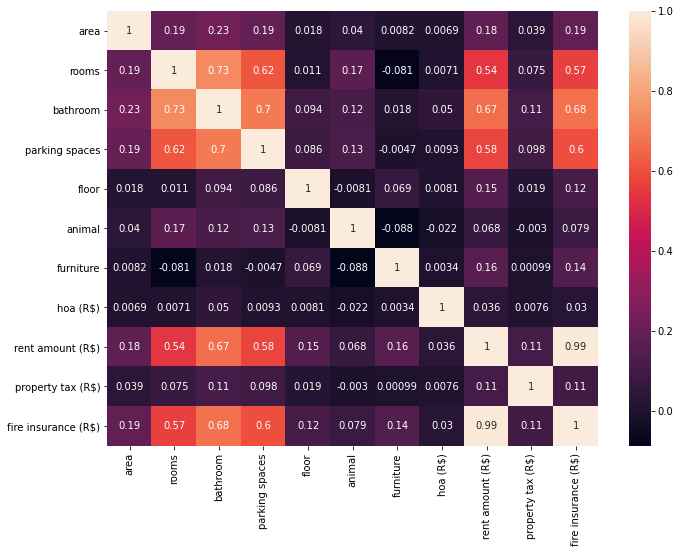

In [0]:
features = correlacoes[(correlacoes['total (R$)'] <= 0.0) | (correlacoes['total (R$)'] >= 0.0) & (correlacoes['total (R$)'] < 1.0)]['total (R$)']
matriz_correlacao = dataset_tratado[features.index.to_list()].corr()
ax = plt.subplots(figsize=(11, 8))
sn.heatmap(matriz_correlacao,  annot=True);

## Plotando os relacionamentos em pares

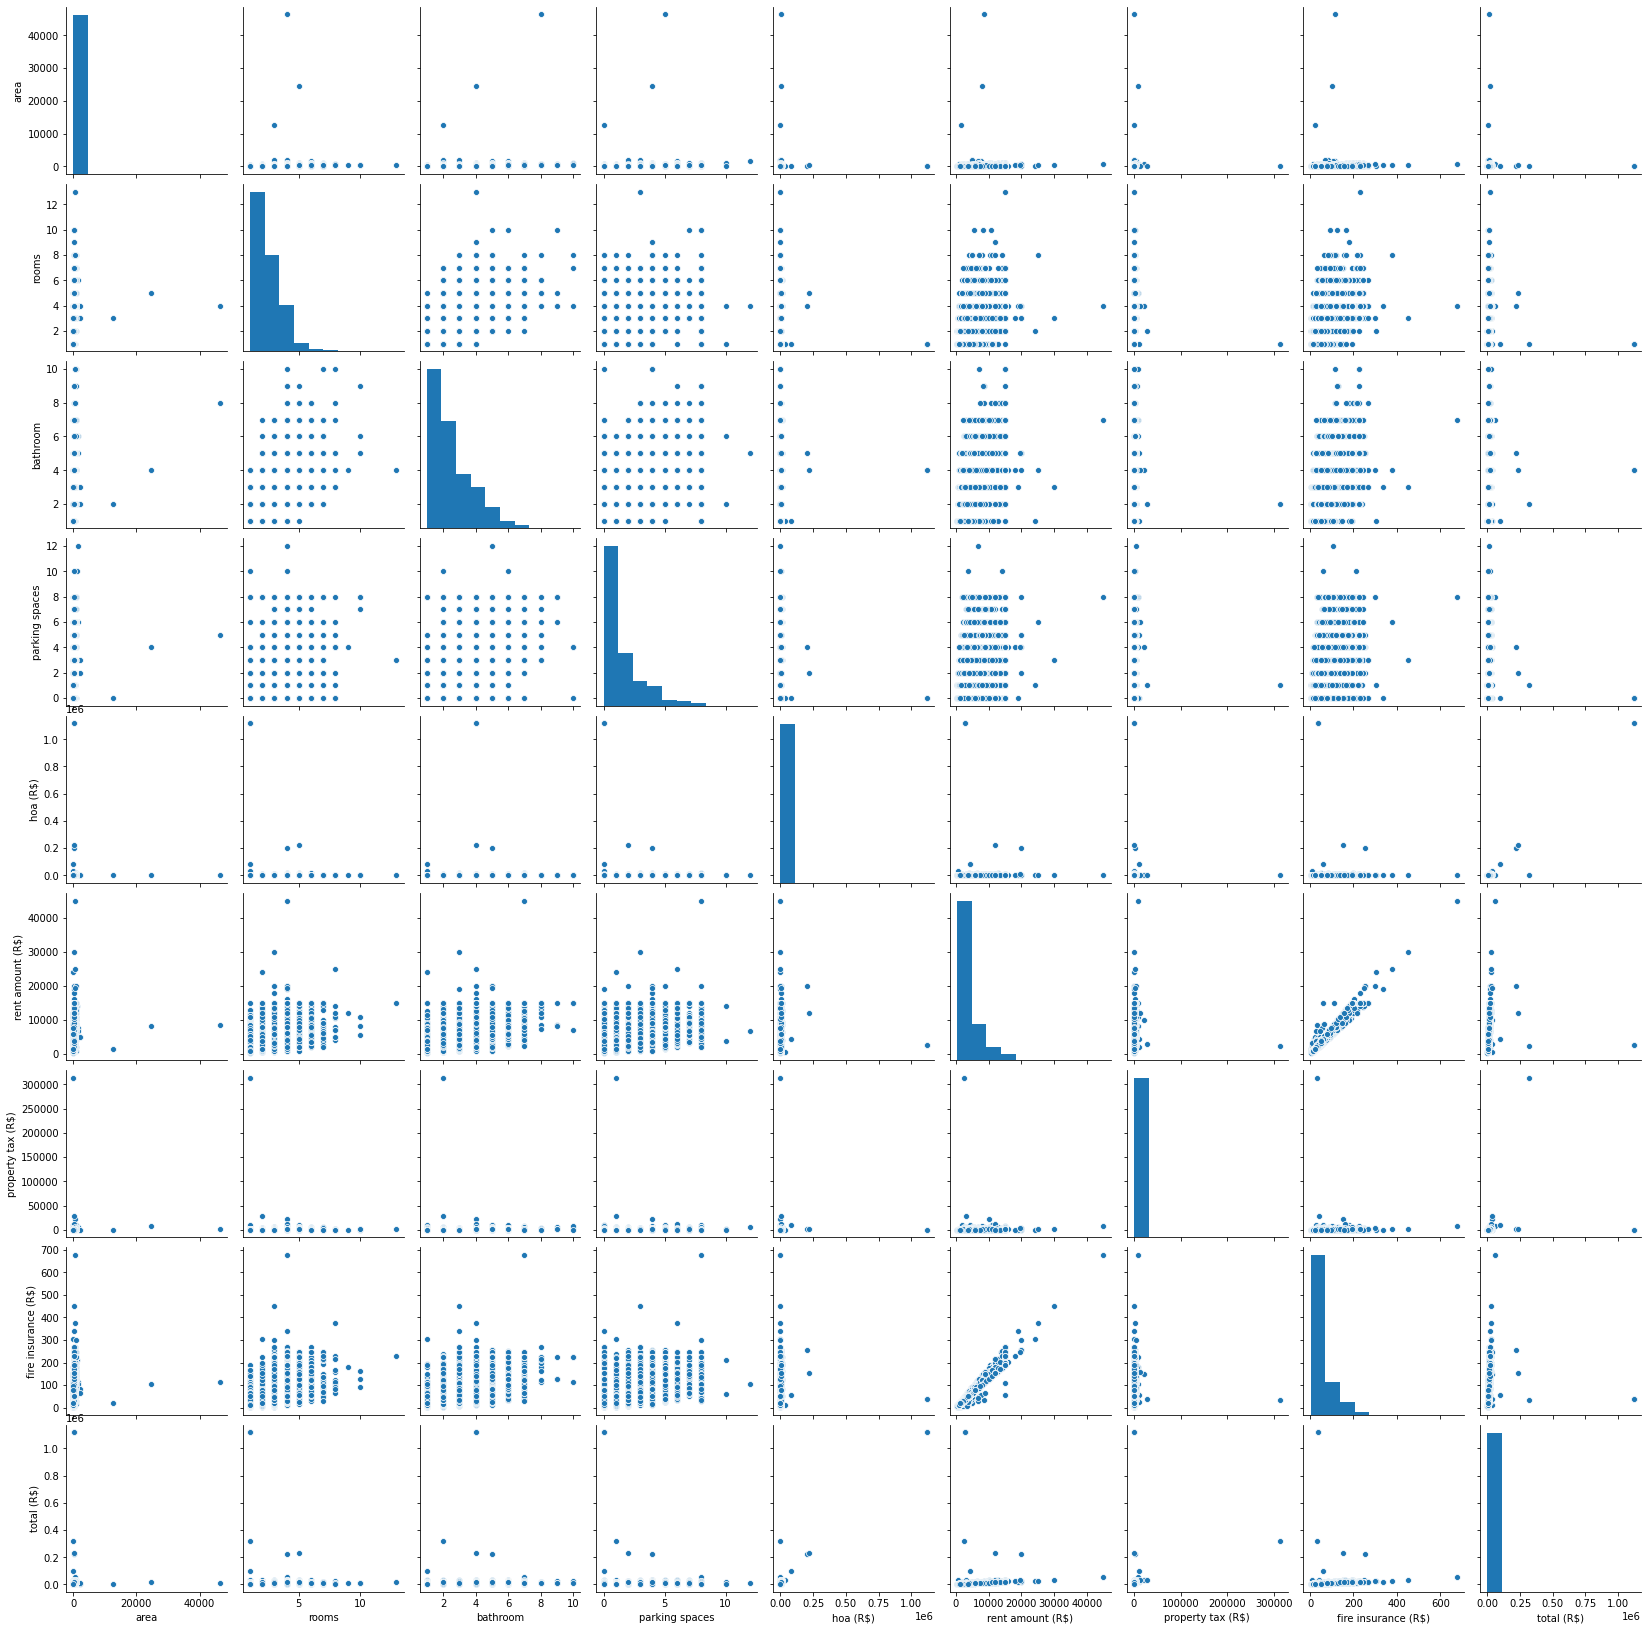

In [0]:
sn.pairplot(dataset_original);

## Montando uma lista das features e avaliando se existem dados nulos

In [0]:
features_lista = features.index.to_list()
features_lista.append('city')
features_lista
dataset_tratado[features_lista].isnull().sum()

area                   0
rooms                  0
bathroom               0
parking spaces         0
floor                  0
animal                 0
furniture              0
hoa (R$)               0
rent amount (R$)       0
property tax (R$)      0
fire insurance (R$)    0
city                   0
dtype: int64

## Categorizando as cidades para inserção no modelo

In [0]:
dataset_city = dataset_tratado.copy()
pd.factorize(dataset_city['city'])
dataset_city['city'] = pd.factorize(dataset_city['city'])[0]

# Montando o modelo

## Divindo os dados entre treinamento e teste

In [0]:
x_train, x_test, y_train, y_test = train_test_split(dataset_city[features_lista], dataset_city['total (R$)'], random_state = 223)

## Criação de uma função para auxiliar na definição do melhor modelo para predição dos dados.

In [0]:

def avalia_melhor_modelo(pipelines,x_train,y_train):
    results = []
    names = []
    for name, model in pipelines:
        kfold = KFold(n_splits=5, random_state=21, shuffle=True)
        cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

In [0]:
pipelines = []
pipelines.append(('lr', Pipeline([('Scaler', MinMaxScaler()),('lr',LinearRegression())])))
pipelines.append(('dtr', Pipeline([('Scaler', MinMaxScaler()),('dtr', DecisionTreeRegressor())])))
pipelines.append(('knn', Pipeline([('Scaler', MinMaxScaler()),('knn', KNeighborsRegressor())])))
pipelines.append(('rfr', Pipeline([('Scaler', MinMaxScaler()),('rfr', RandomForestRegressor())])))

In [0]:
avalia_melhor_modelo(pipelines, x_train, y_train)

lr: -31.727368 (33.794982)
dtr: -99678694.950639 (195418097.200864)
knn: -140469900.277602 (247567977.302584)
rfr: -121575959.081613 (236461328.062116)


### Os algoritmos com melhor desempenho foram  o LinearRegression e o DecisionTreeRegressor por apresentar um menor erro médio.

# LinearRegression

## Treinando o modelo de regressão linear

In [0]:
lr = LinearRegression().fit(x_train, y_train)
lr.score(x_train, y_train)
previsao = lr.predict(x_test)
R_2 = metrics.r2_score(y_test, previsao)
print("Coeficiente de Determinação (R2):", R_2)

Coeficiente de Determinação (R2): 0.9999998948139663


In [0]:
dataset_resultado = x_test.copy()
dataset_resultado['total real'] = y_test
dataset_resultado['total previsto'] = previsao.astype('int')
dataset_resultado['city'] = dataset_resultado['city'].map({0 : 'São Paulo', 1 : 'Porto Alegre', 2 : 'Rio de Janeiro', 3 : 'Campinas', 4 : 'Belo Horizonte'})

## Apresentado o resultado da previsão entre as colunas total real e total previsto

In [0]:
dataset_resultado[['city', 'total real', 'total previsto']].head(10)

,city,total real,total previsto
8717,São Paulo,5941,5941
9369,São Paulo,4009,4009
4512,São Paulo,3355,3355
4411,Rio de Janeiro,3384,3384
9675,São Paulo,16050,16049
4894,São Paulo,3031,3031
3145,Campinas,3419,3419
4967,São Paulo,3640,3639
4942,Rio de Janeiro,1725,1725
2254,Porto Alegre,3388,3388


# DecisionTreeRegressor

## Treinando o modelo árvore de decisão

In [0]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train,y_train)
previsao = dtr.predict(x_test)
R_2 = metrics.r2_score(y_test, previsao)
print("Coeficiente de Determinação (R2):", R_2)

Coeficiente de Determinação (R2): 0.9282070681220514


In [0]:
dataset_resultado = x_test.copy()
dataset_resultado['total real'] = y_test
dataset_resultado['total previsto'] = previsao.astype('int')
dataset_resultado['city'] = dataset_resultado['city'].map({0 : 'São Paulo', 1 : 'Porto Alegre', 2 : 'Rio de Janeiro', 3 : 'Campinas', 4 : 'Belo Horizonte'})

## Apresentado o resultado da previsão entre as colunas total real e total previsto

In [0]:
dataset_resultado[['city', 'total real', 'total previsto']].head(10)

,city,total real,total previsto
8717,São Paulo,5941,6050
9369,São Paulo,4009,4070
4512,São Paulo,3355,3521
4411,Rio de Janeiro,3384,3573
9675,São Paulo,16050,17390
4894,São Paulo,3031,3156
3145,Campinas,3419,3418
4967,São Paulo,3640,3731
4942,Rio de Janeiro,1725,1767
2254,Porto Alegre,3388,3433


# Conclusão

## A regressão linear teve um excelente ajuste ao modelo, explicando 99% da variância da variável dependente a partir dos regressores, nota-se a acertividade da previsão visualizado o resultado gerado pela previsão do modelo de regressão linear.

## Em contrapartida o modelo de árvore de decisão embora apresente um r2 score de 92% não conseguiu uma previsão muito bem ajustada.